# Case Study: System Analysis
*Author: S.A. Klop*

This notebook discusses how a hydrological system can be analyzed using time series analysis. A network of multiple monitoring wells is considered. By developing and analyzing time series models for all these wells, information about the system can be obtained.

**Table of Contents**

- [Lowering of Nature Area](#Lowering-of-Nature-Area)
    - [Available Data](#Available-Data)
    - [Developing the Time Series Model](#Developing-the-Time-Series-Model)
    - [Lowering Due to Extraction](#Lowering-Due-to-Extraction)



In [1]:
# inladen van de benodigde python packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML

import pastas as ps

%matplotlib inline
ps.set_log_level("ERROR")

%config InlineBackend.figure_format = 'retina'

/Applications/anaconda3/envs/mude/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (

## Lowering of Nature Area
Near a nature area, there is an extraction point for a large industrial complex. The water authority suspects that this extraction may be causing a decline in the hydraulic head in the area, which is not permitted under the terms of the permit. Therefore, the water authority decides to investigate whether groundwater level measurements can demonstrate that the extraction has caused a reduction in hydraulic head. This is analyzed using time series analysis.

The extraction point is located 500 meters from the nature area. Water is extracted from the first aquifer, which is also the layer where the monitoring wells are located.


## Available Data
Around the extraction point, the water authority has groundwater level data available from monitoring wells PB1, PB2, and PB3. These wells have relatively long time series, each with its own start and end period. Unfortunately, none of these wells have recorded hydraulic head in recent years. The time series for each well are shown in the figures below.

The distances from the wells to the extraction point have been determined and are shown in the table below.

| Monitoring Well | Distance [m] |  
| --------------- |:------------:|  
| PB1             | 112          |  
| PB2             | 180          |  
| PB3             | 321          |  

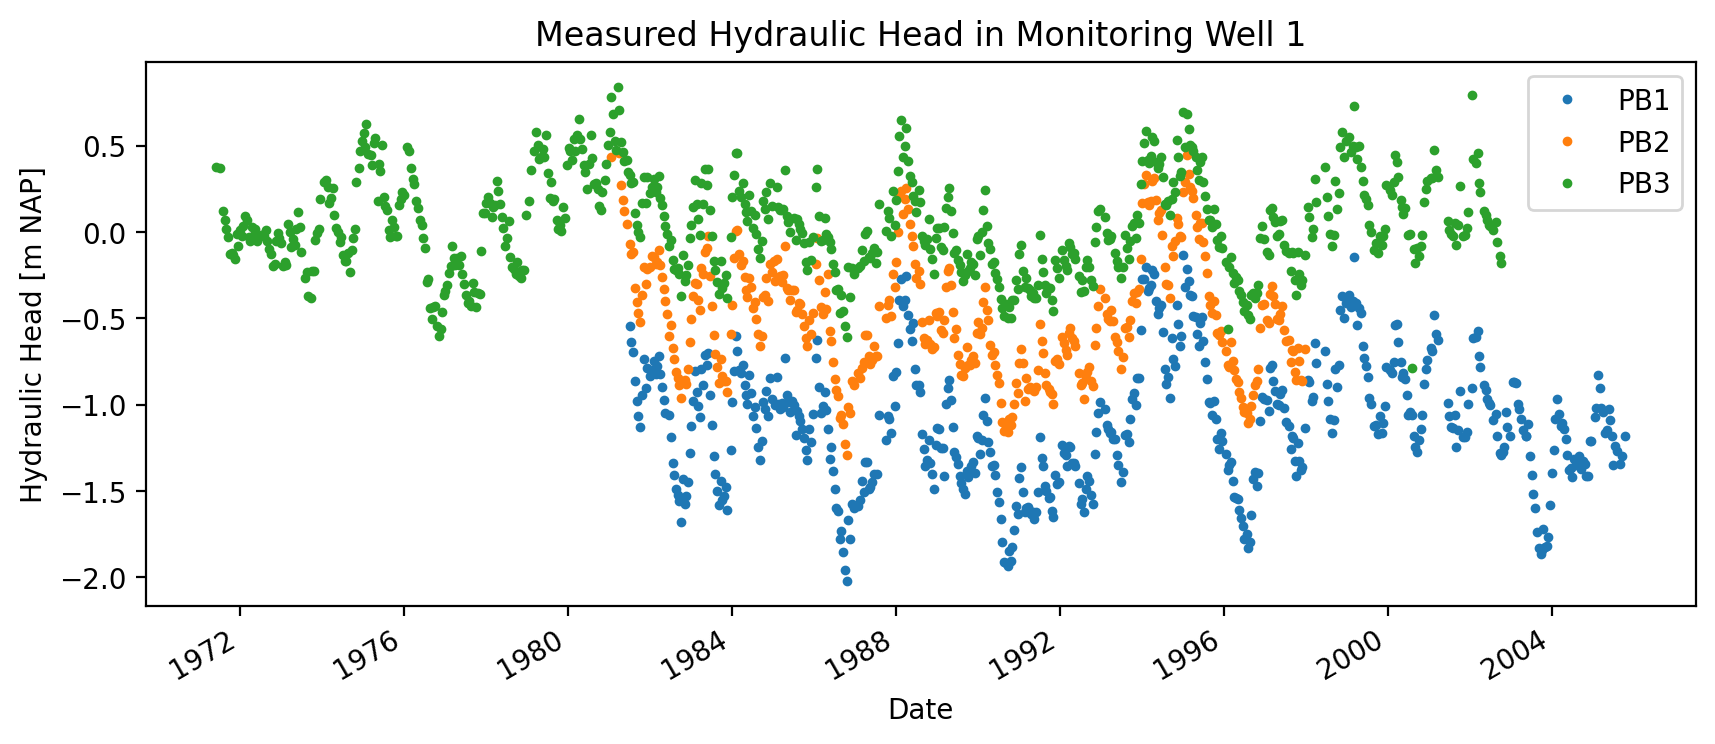

In [2]:
PB1 = pd.read_csv("data/PB1_c.csv", index_col=0, parse_dates=True, names=["Date", "PB1"], header=0).squeeze()
PB1.index = pd.to_datetime(PB1.index, errors='coerce')
PB1 = PB1.loc[PB1.index.dropna()]

PB2 = pd.read_csv("data/PB2_c.csv", index_col=0, parse_dates=True, names=["Date", "PB2"], header=0).squeeze()
PB2.index = pd.to_datetime(PB2.index, errors='coerce')
PB2 = PB2.loc[PB2.index.dropna()]

PB3 = pd.read_csv("data/PB3_c.csv", index_col=0, parse_dates=True, names=["Date", "PB3"], header=0).squeeze()
PB3.index = pd.to_datetime(PB3.index, errors='coerce')
PB3 = PB3.loc[PB3.index.dropna()]

PB1 = PB1[~PB1.index.duplicated(keep='first')]
PB2 = PB2[~PB2.index.duplicated(keep='first')]
PB3 = PB3[~PB3.index.duplicated(keep='first')]

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
PB1.plot(ax=ax, ls='', marker='.', markersize=5)
PB2.plot(ax=ax, ls='', marker='.', markersize=5)
PB3.plot(ax=ax, ls='', marker='.', markersize=5)


ax.set_ylabel('Hydraulic Head [m NAP]')
ax.set_xlabel('Date')
ax.set_title('Measured Hydraulic Head in Monitoring Well 1')
ax.legend();

In [3]:
PB1

Date
1981-07-03   -0.543082
1981-07-17   -0.637663
1981-07-30   -0.695771
1981-08-19   -0.865806
1981-09-02   -0.979136
                ...   
2005-07-14   -1.237293
2005-07-28   -1.268672
2005-08-29   -1.345807
2005-09-14   -1.300408
2005-10-14   -1.184775
Name: PB1, Length: 544, dtype: float64

To develop a time series model for the hydraulic head time series, precipitation and evaporation are used. For this purpose, data from the nearest KNMI weather station has been used. The precipitation and evaporation are shown in the figure below. This weather station is the closest for all monitoring wells.

Columns (2,3,4,5,6,7,8,13,15,16,18,19,20,21,22,23,25,26,28,30,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.

(9131.0, 18651.0)

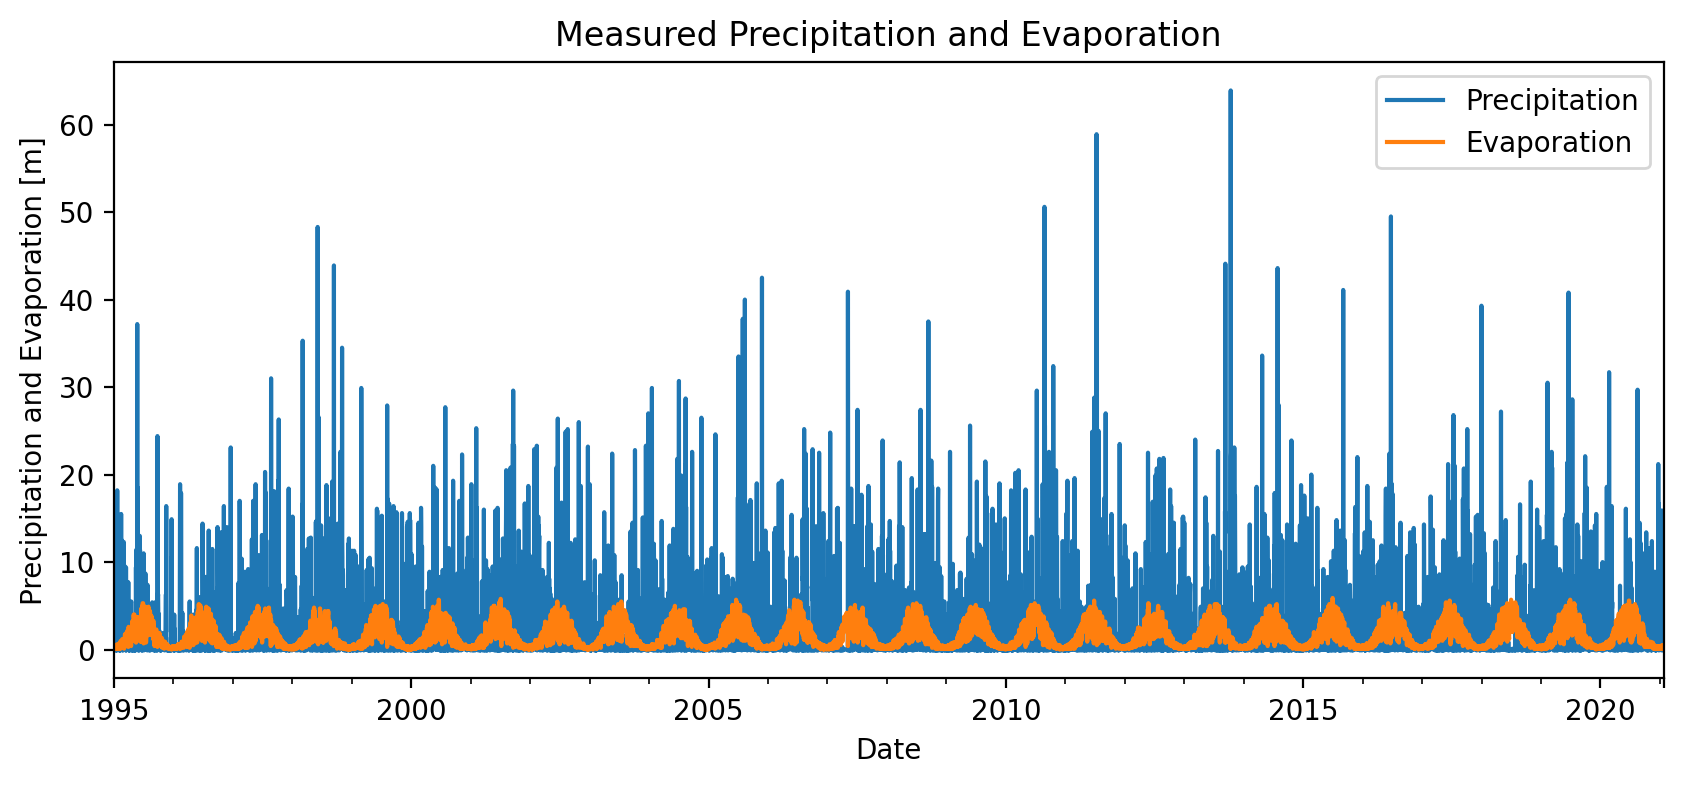

In [4]:
raw = pd.read_csv('data/etmgeg_260.txt', skiprows=47, index_col=1, parse_dates=True)

rain = pd.to_numeric(raw['   RH'], errors='coerce') / 10 
evap = pd.to_numeric(raw[' EV24'], errors='coerce') / 10

rain.name = "Precipitation"
evap.name = "Evaporation"

# Plotting precipitation and evaporation
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
rain.plot(ax=ax, color='C0')
evap.plot(ax=ax, color='C1')

# Formatting the figure
ax.set_ylabel('Precipitation and Evaporation [m]')
ax.set_xlabel('Date')
ax.set_title('Measured Precipitation and Evaporation')
ax.legend(['Precipitation', 'Evaporation'])
ax.set_xlim(xmin='1995')

To investigate the effect of the extraction on the measured hydraulic head, the time series data for the extraction was obtained from the owner of the extraction point. The extraction began in the 1960s. It has varied over the years and has been slightly reduced since 2010.

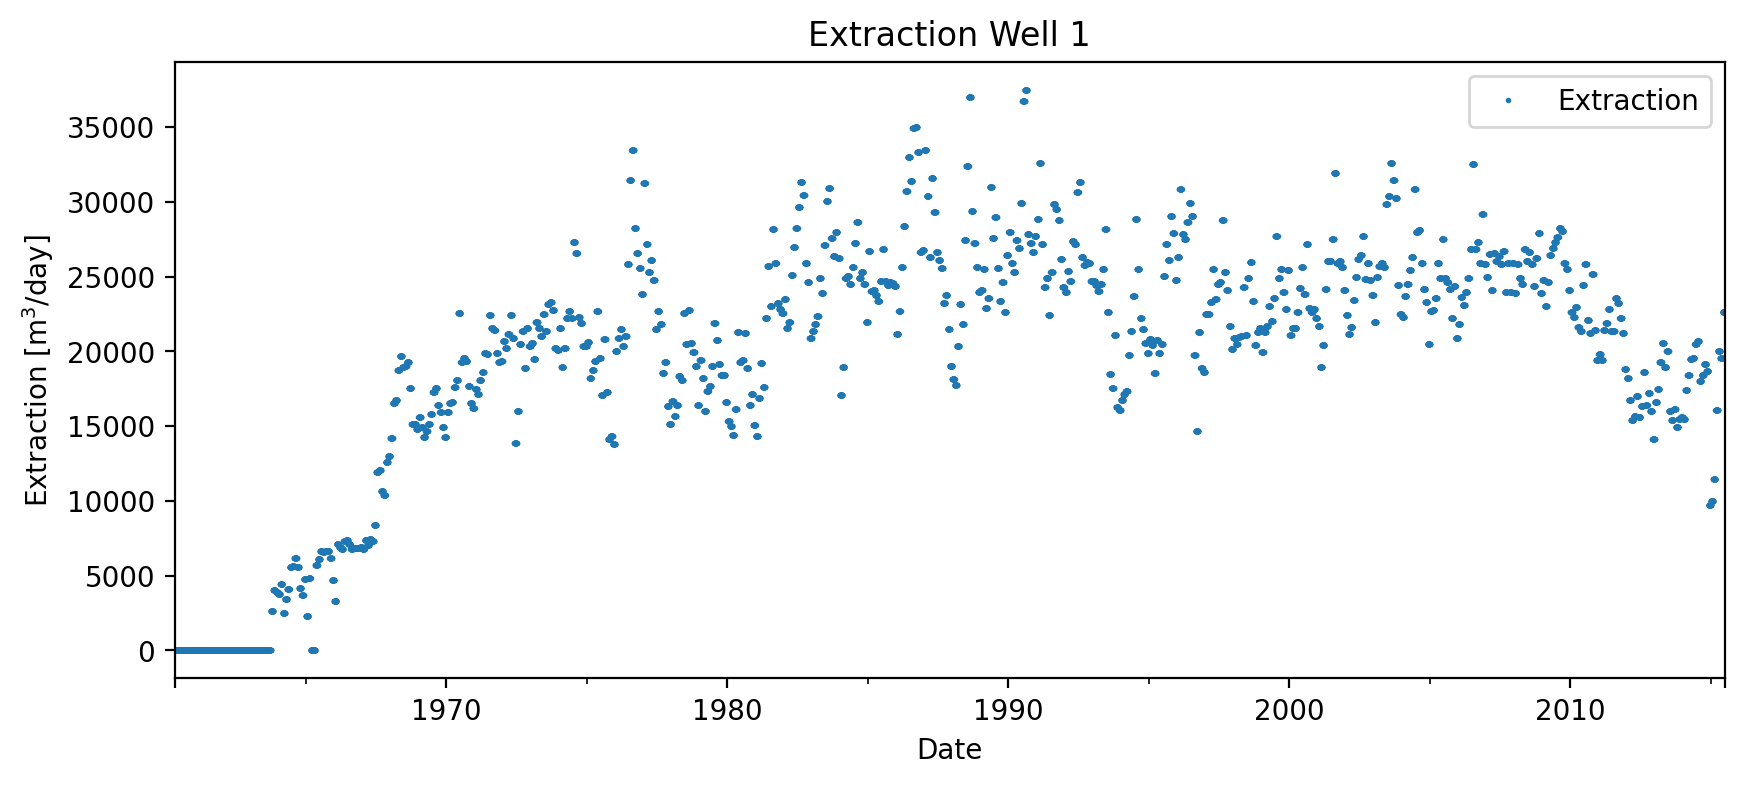

In [5]:
well = pd.read_csv("data/well.csv", index_col=0, parse_dates=True, names=["Date", "well"], header=0)

# Plotting the extraction
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
well.plot(ax=ax, color='C0', ls='', marker='.', markersize=2)

# Formatting the figure
ax.set_ylabel('Extraction [m$^3$/day]')
ax.set_xlabel('Date')
ax.set_title('Extraction Well 1')
ax.legend(['Extraction'])


### Developing the Time Series Model

A model is developed for the hydraulic head observations, with a separate model set up for each monitoring well. The full time series is used for all wells. No outliers were found in the data, so there is no need for preprocessing the measurement series.

Precipitation and evaporation are used as explanatory series. A response function is chosen for these explanatory inputs. The response function describes how the hydraulic head reacts to an external influence. For the time series models, the Gamma response function is chosen for both precipitation and evaporation. This response function is individually optimized for each time series model.

In the model, the same response function is used for both precipitation and evaporation. The relationship between them is described by the formula  
$R = P - f \cdot E$,  
where $R$ is the groundwater recharge [m], $P$ is the precipitation [m], $f$ is the evaporation factor [-], and $E$ is the evaporation [m]. The evaporation factor is optimized by the time series model.

In addition, the extraction is also used as an explanatory series. For this explanatory series, the Hantush response function is chosen. Besides the explanatory variables, the constant term (denoted as *d* in the model) is also optimized.

With these explanatory series and chosen response functions, the time series models are optimized.

In [6]:
# Set up the model
ml = ps.Model(PB1)

# Add precipitation and evaporation as explanatory series
sm1 = ps.RechargeModel(rain, evap, rfunc=ps.Gamma(), name='recharge')

# Add extraction as an explanatory series
sm2 = ps.StressModel(stress=well, rfunc=ps.Hantush(), name='extraction',
                     settings='well', up=False)
ml.add_stressmodel([sm1, sm2])

# Solve the time series model
ml.solve(report=False)

# Simulate the groundwater head
gws_simulation1 = ml.simulate()


The time series model for PB1 has an R² of 0.93. Using the model, the observed hydraulic head can be simulated accurately. The simulation of the time series model for PB1 is shown in the figure below. In this figure, the effect of each input series is shown as a separate contribution. It can be seen that the extraction causes the hydraulic head to decrease by approximately -2.5 to -1.5 meters.


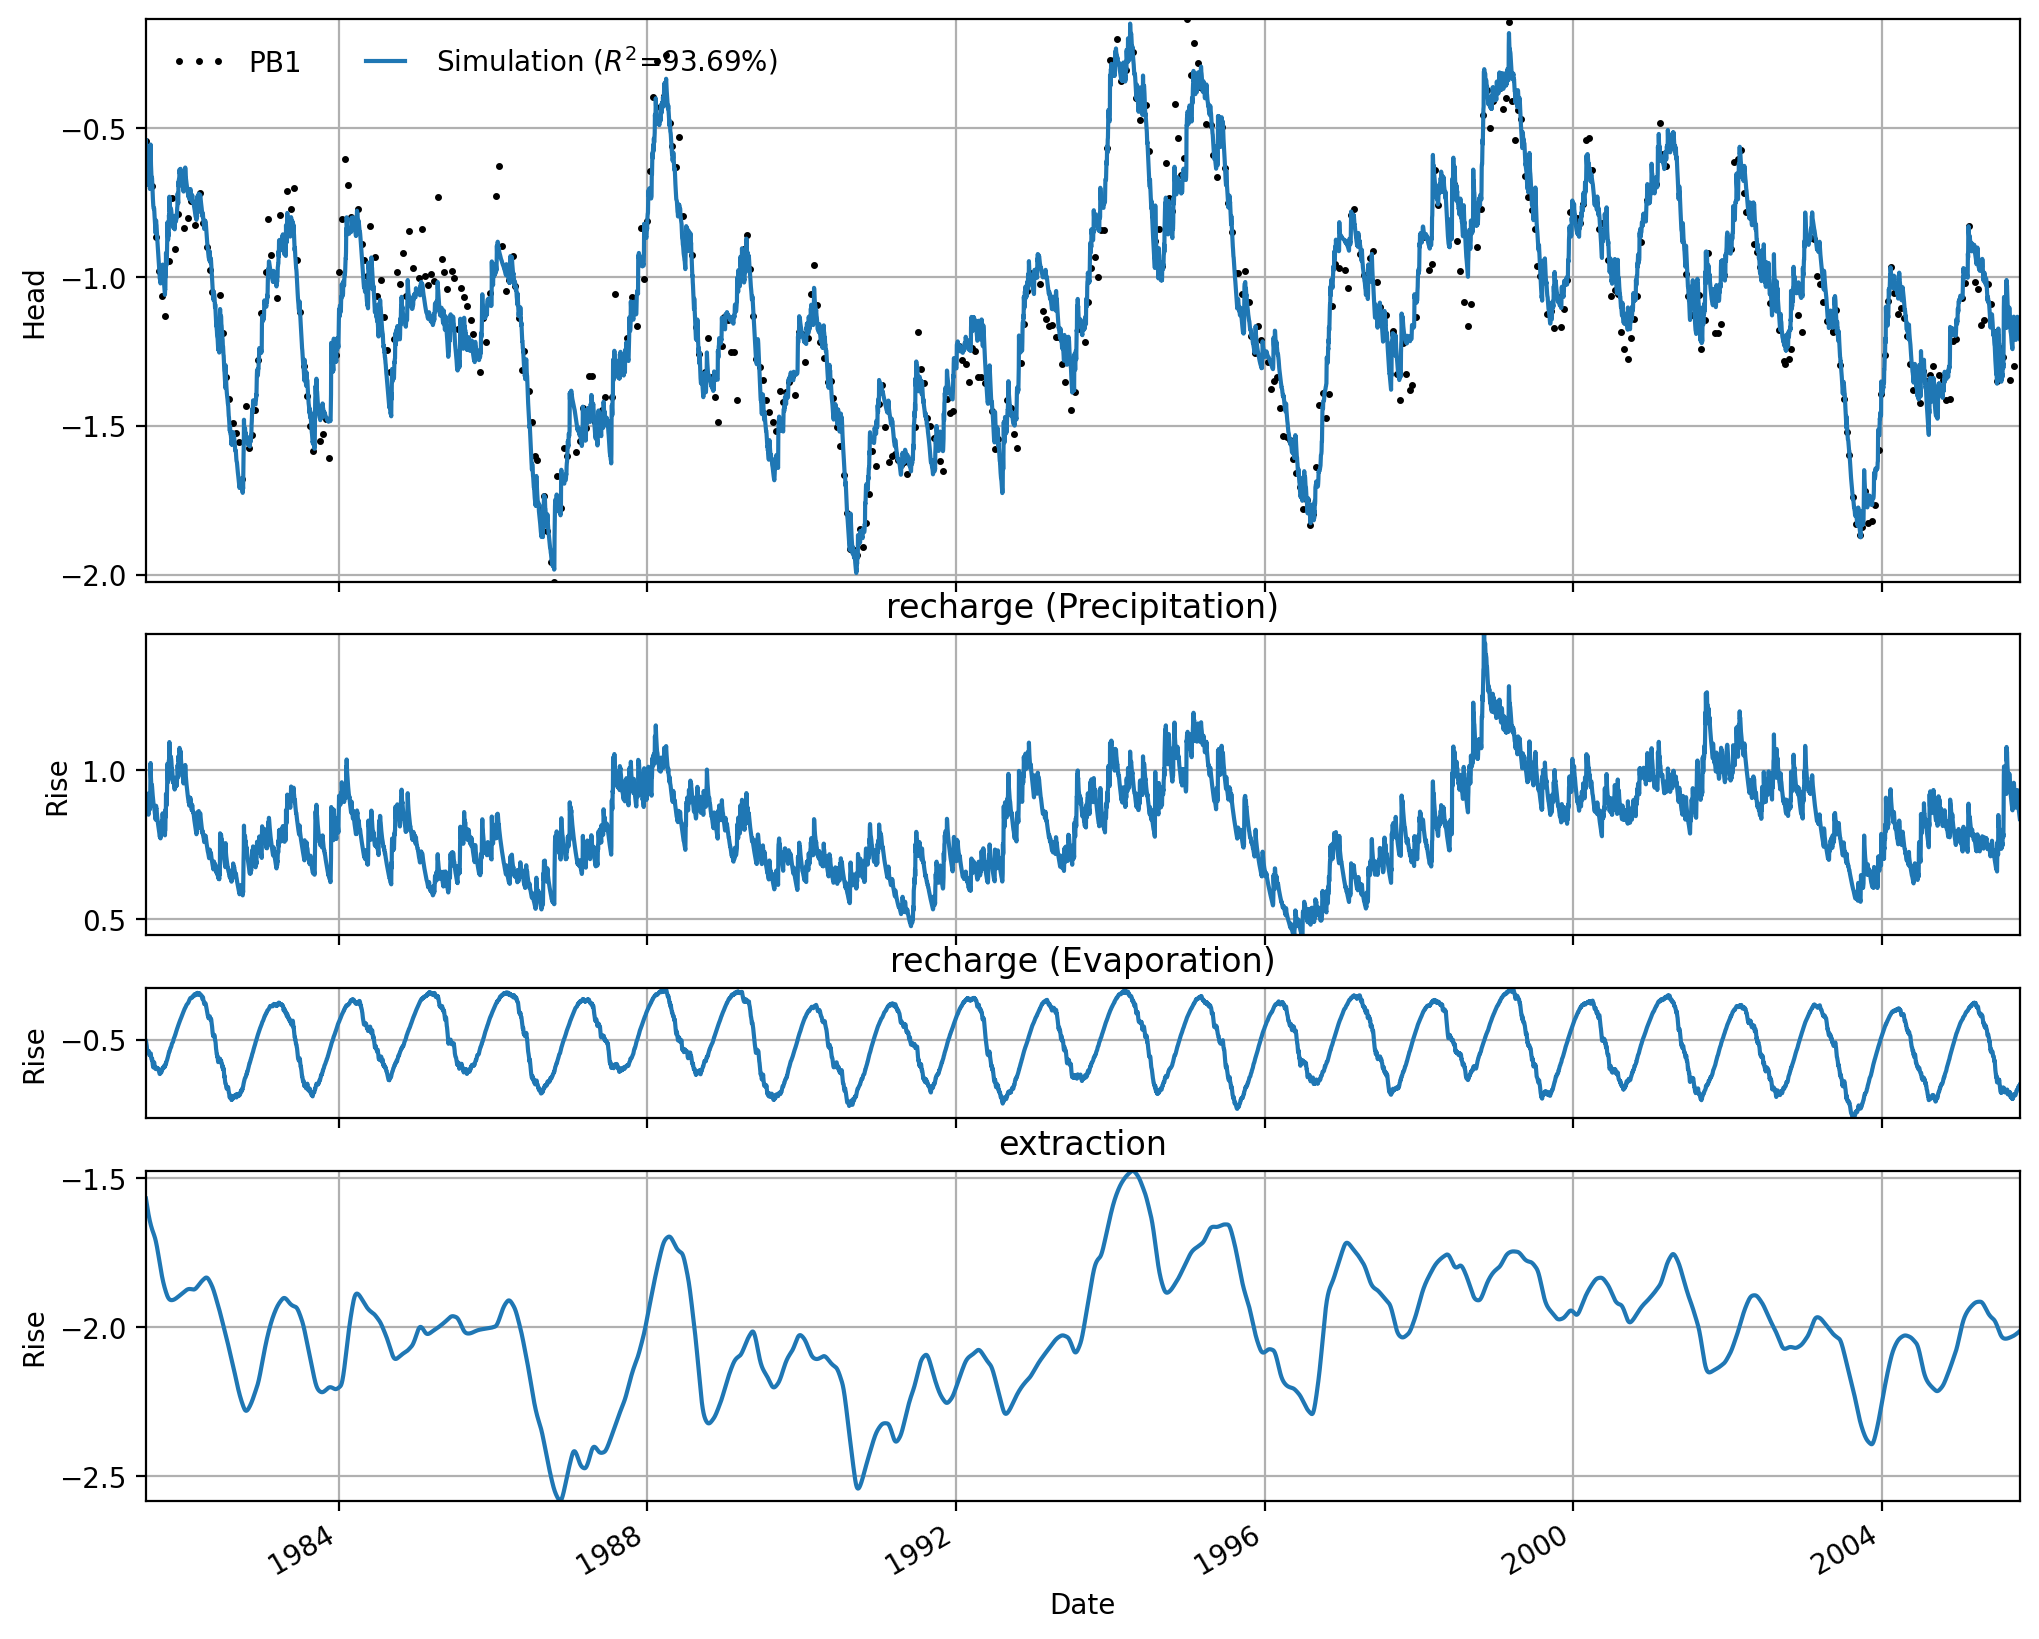

In [7]:
ml.plots.decomposition(figsize=(10, 8));

For monitoring well PB2, a time series model was set up using the same explanatory series.

In [8]:
# Set up the model
ml2 = ps.Model(PB2)

# Add precipitation and evaporation as explanatory series
sm1 = ps.RechargeModel(rain, evap, rfunc=ps.Gamma(), name='recharge')

# Add extraction as an explanatory series
sm2 = ps.StressModel(stress=well, rfunc=ps.Hantush(), name='extraction',
                     settings='well', up=False)
ml2.add_stressmodel([sm1, sm2])

# Solve the time series model
ml2.solve(report=False)

# Simulate the groundwater head
gws_simulation2 = ml2.simulate()

It can be seen that the time series model has an R² of 0.91. The figure below shows the simulated hydraulic head. In addition, the contribution of each influencing factor is shown separately. It can be observed that the extraction causes the hydraulic head to decrease by approximately -1 to -2 meters. This decrease is less than the one determined at the location of PB1. This matches the hydrological expectation, as PB2 is located farther from the extraction point than PB1.


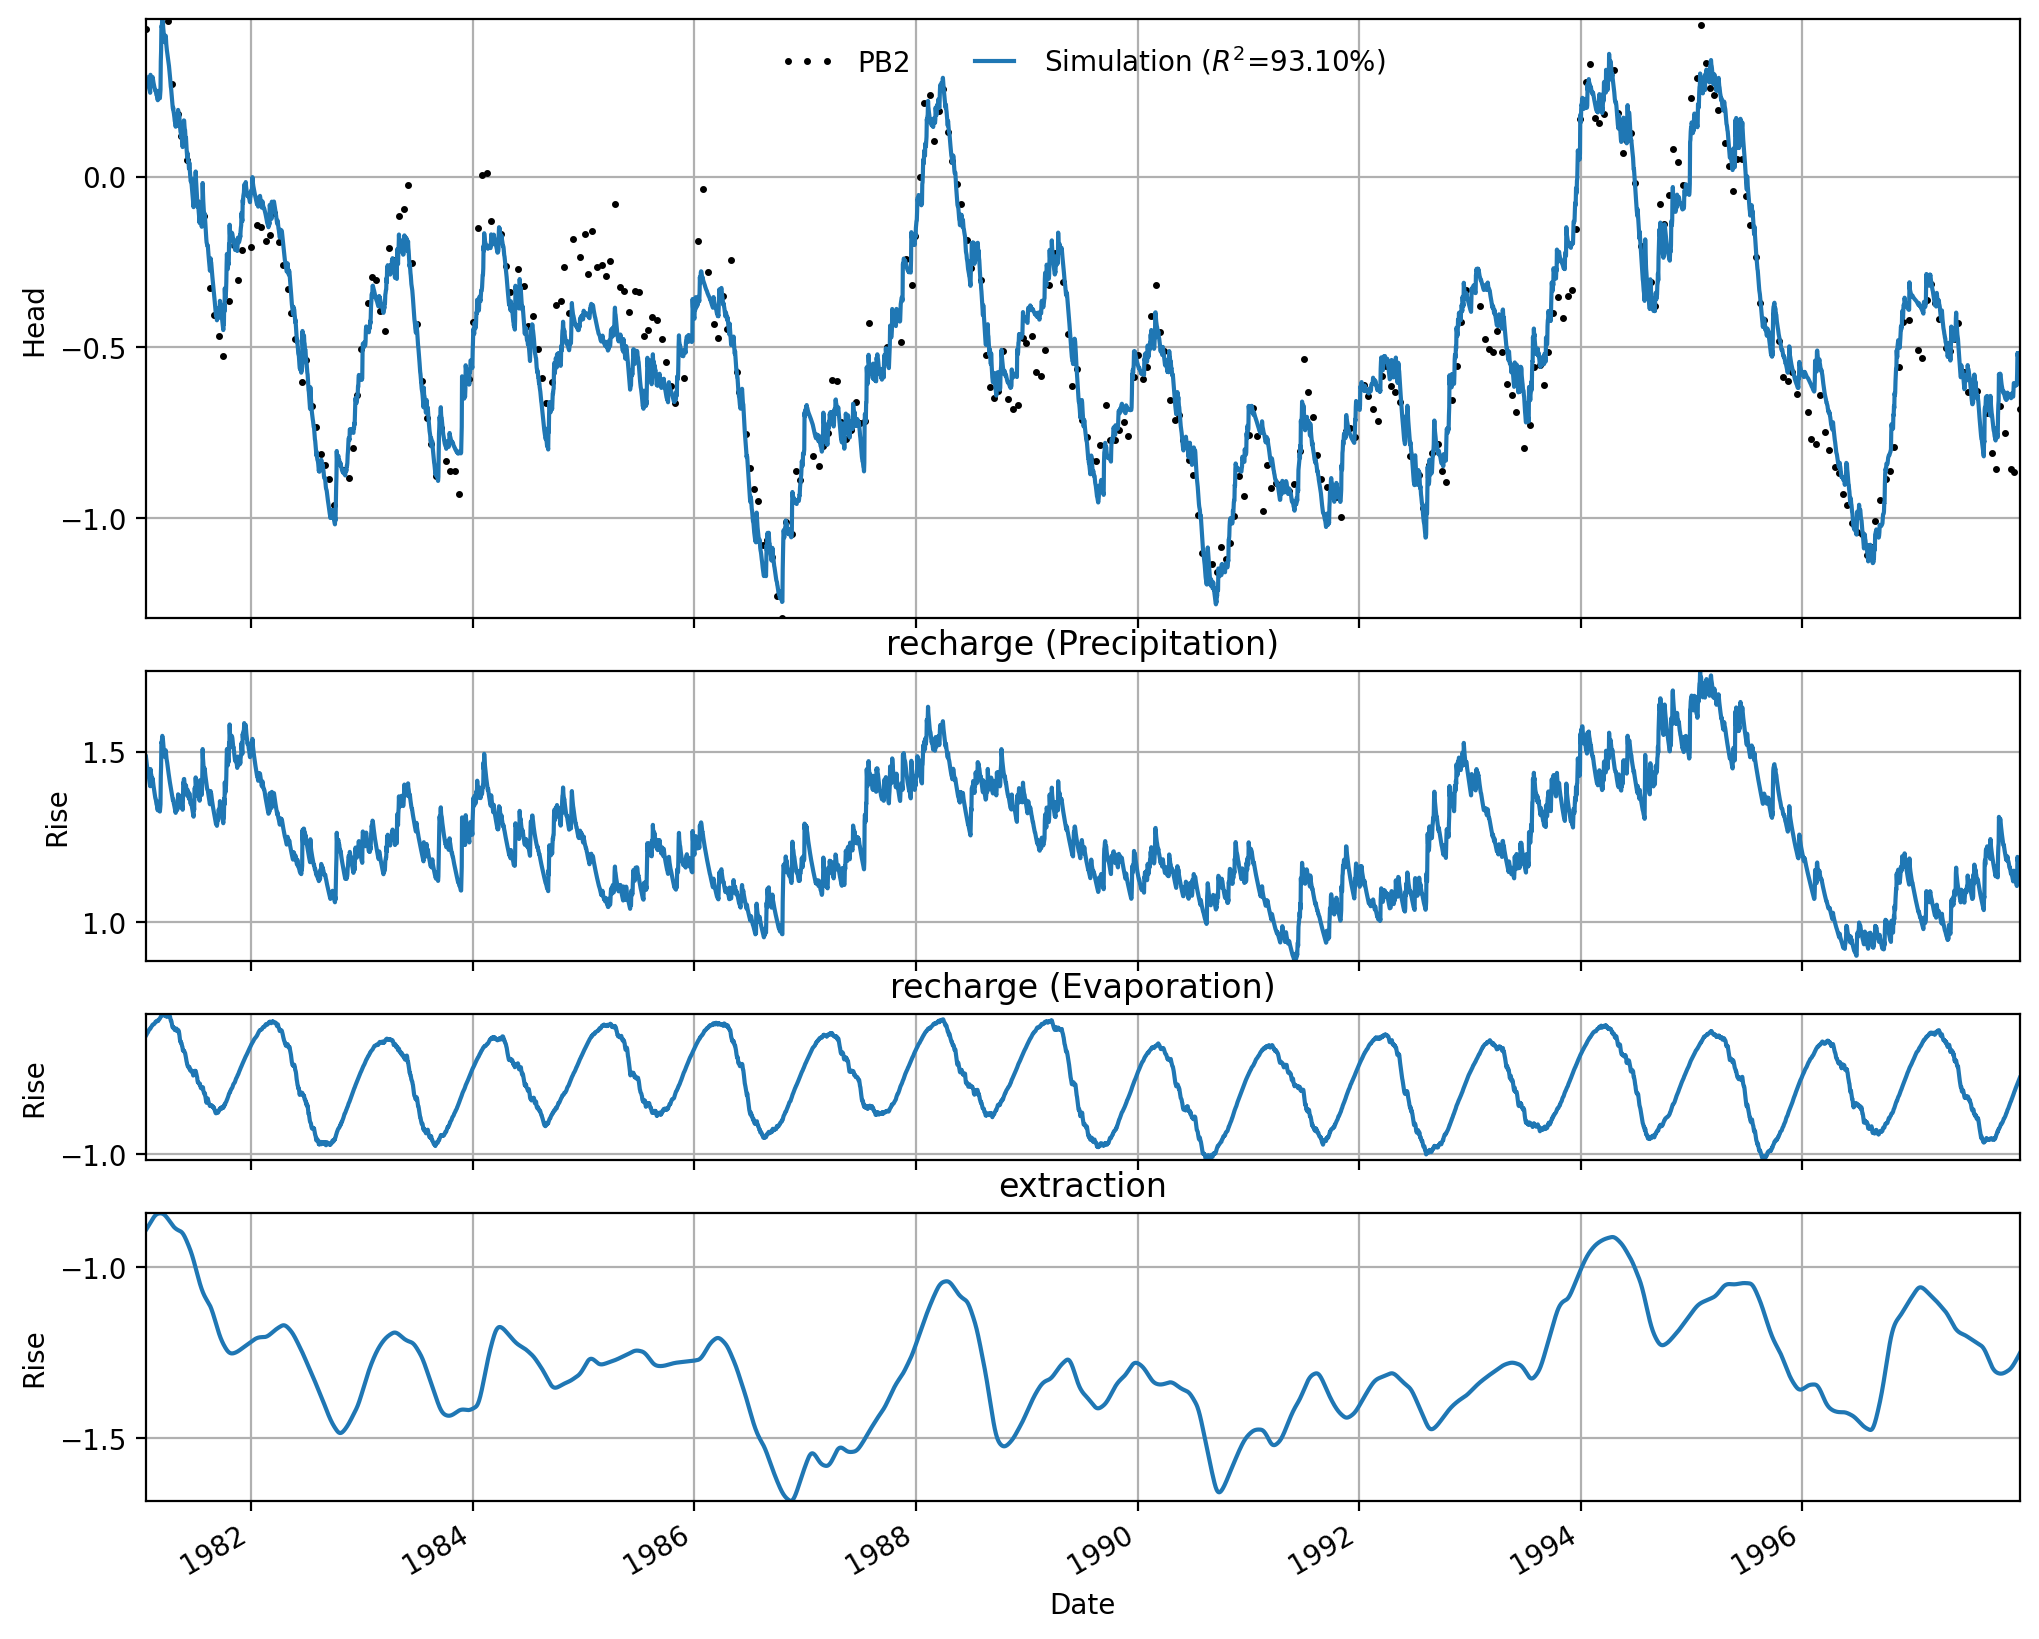

In [9]:
ml2.plots.decomposition(figsize=(10, 8));

Finally, a time series model was also developed for monitoring well PB3.

In [10]:
# Set up the model
ml3 = ps.Model(PB3)

# Add precipitation and evaporation as explanatory series
sm1 = ps.RechargeModel(rain, evap, rfunc=ps.Gamma(), name='recharge')

# Add extraction as an explanatory series
sm2 = ps.StressModel(stress=well, rfunc=ps.Hantush(), name='extraction',
                     settings='well', up=False)
ml3.add_stressmodel([sm1, sm2])

# Solve the time series model
ml3.solve(report=False)

# Simulate the groundwater head
gws_simulation3 = ml3.simulate()

The time series model has an R² of 0.86. The simulated series is shown in the figure below. The contribution of each influencing factor is displayed. This shows the effect of each input series as modeled. It can be seen that the decrease in hydraulic head due to the extraction is approximately between -0.5 and -1 meter. At this distance, the effect of the extraction is still visible in the hydraulic head time series.


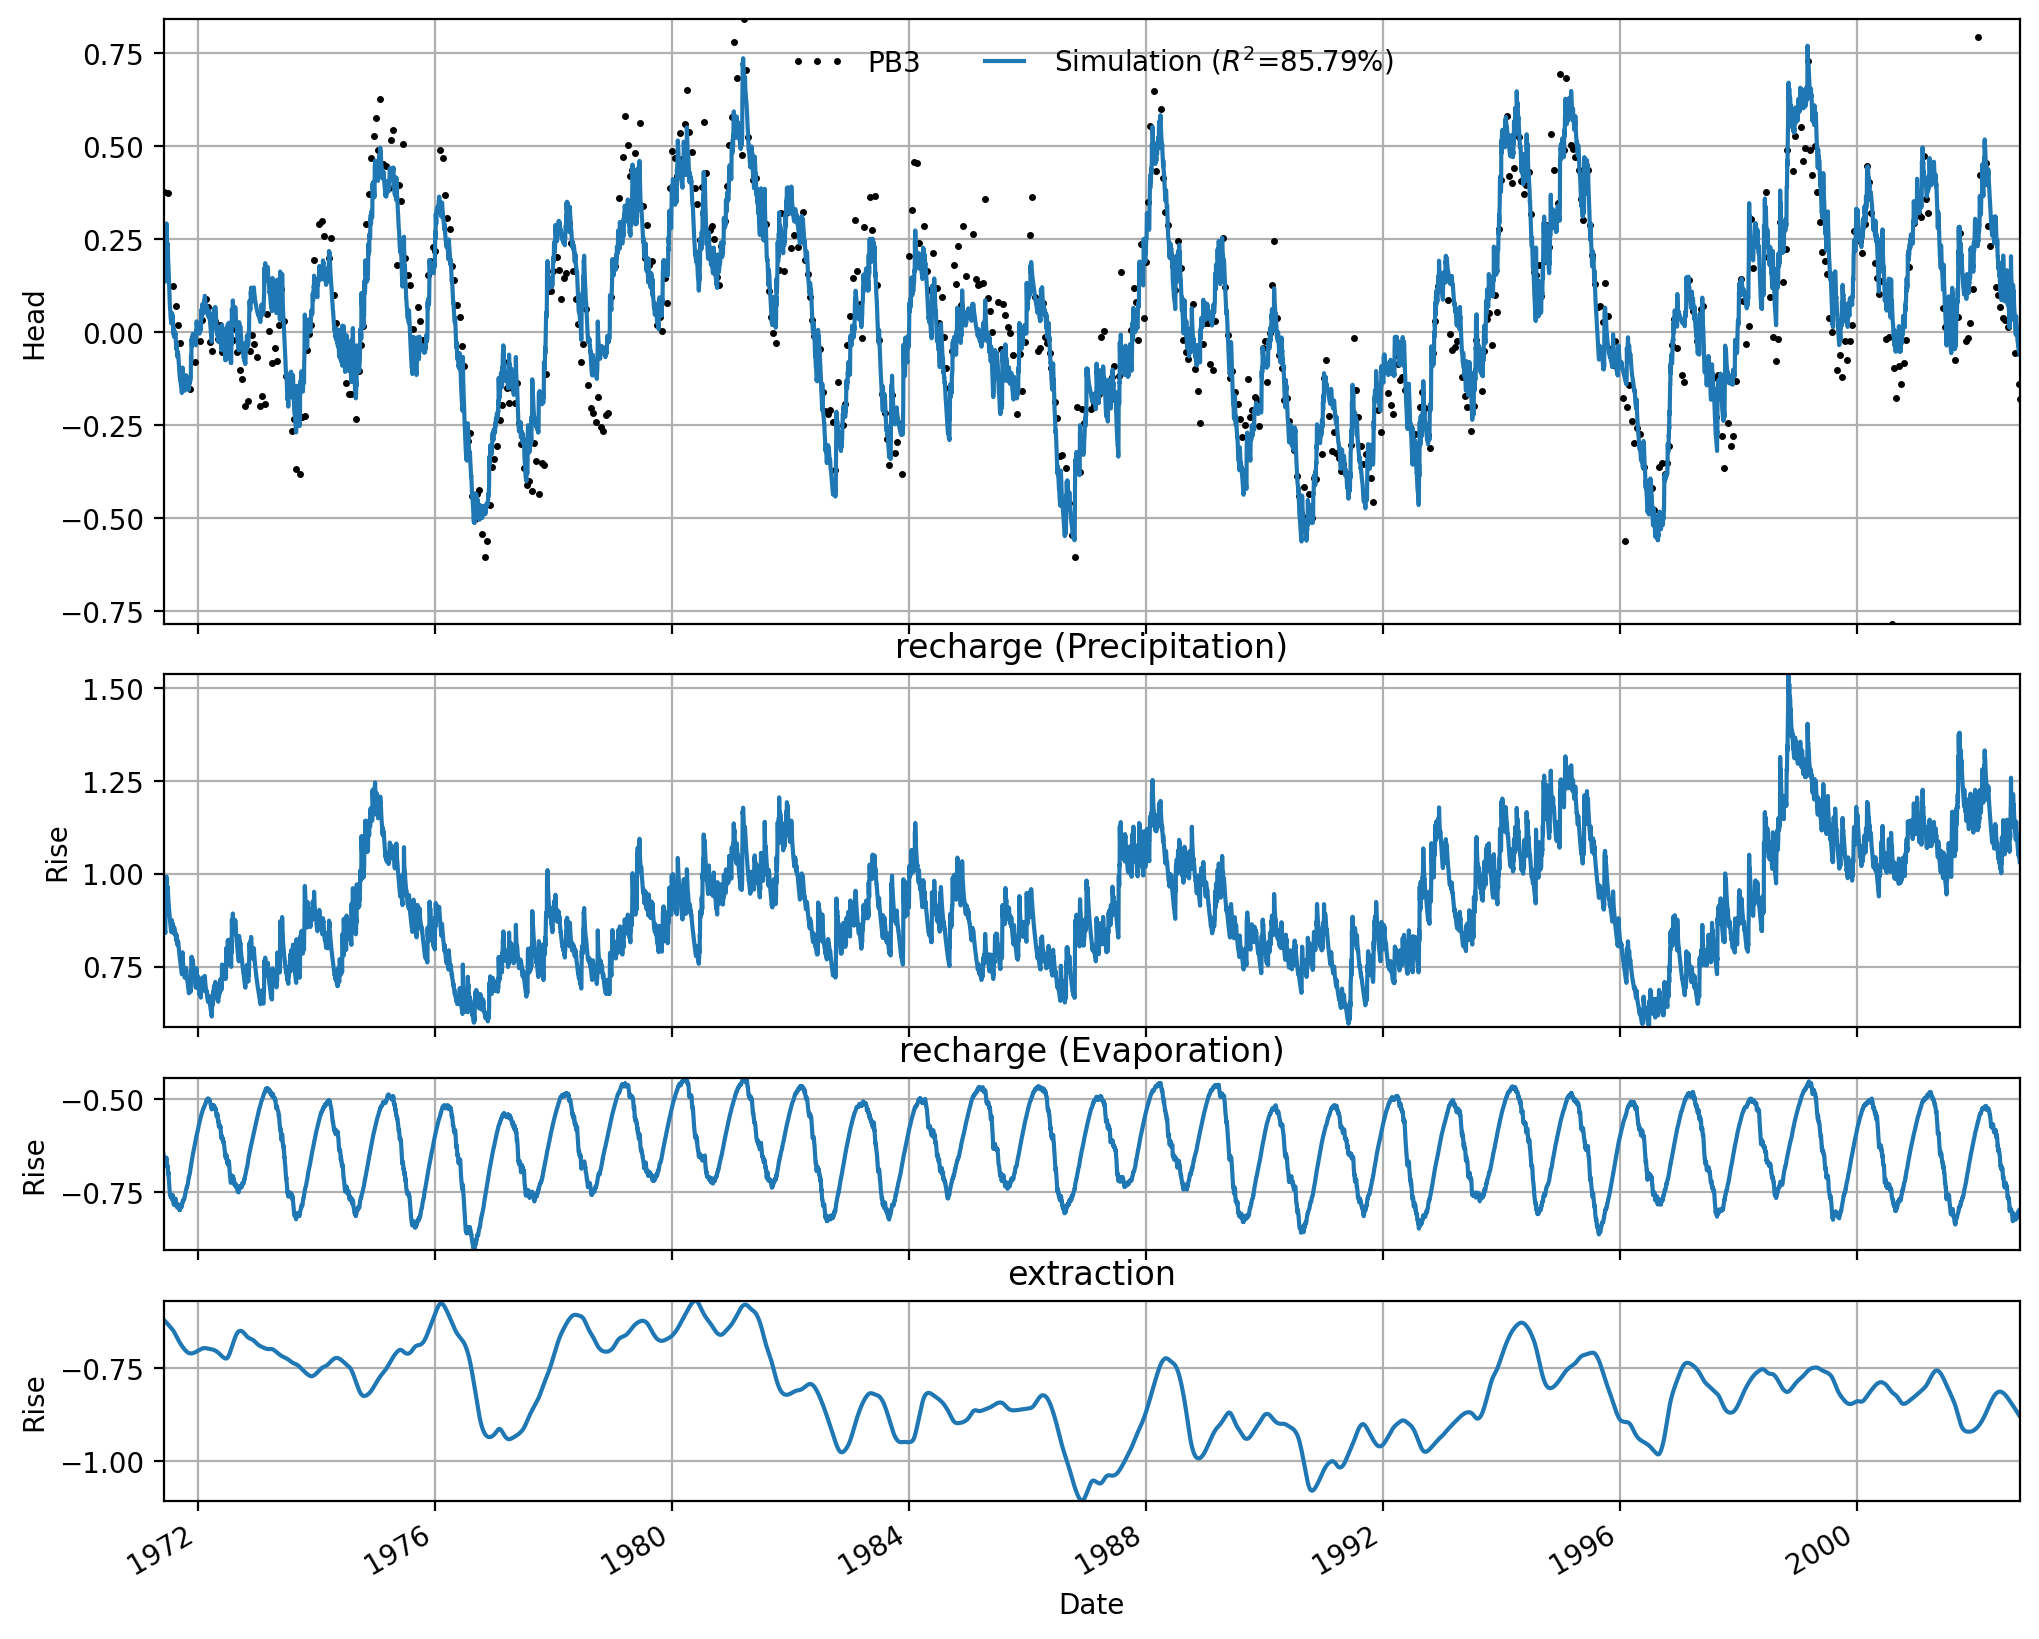

In [11]:
ml3.plots.decomposition(figsize=(10, 8));

## Lowering Due to Extraction

The table below presents the average reductions as determined through the time series analysis. Since the monitoring wells have different measurement periods, the average extraction during each period is considered, and the average reduction per 10,000 m³/day is calculated.

| Monitoring Well | Distance [m] | Average Lowering [m] | Average Extraction [m³/day] | Average Lowering per 10,000 m³/day [m] |
|-----------------|:------------:|:---------------------:|:----------------------------:|:--------------------------------------:|
| PB1             | 112          | -2.12                 | 24,985                       | -0.85                                   |
| PB2             | 180          | -1.57                 | 25,129                       | -0.63                                   |
| PB3             | 321          | -0.81                 | 23,448                       | -0.35                                   |

In the figure below, the average calculated reductions per 10,000 m³/day are plotted against the distance to the extraction well. The aquifer in the area is uniform, so it is expected that at a distance of 500 meters — the distance between the nature area and the extraction — a significant reduction will occur due to the extraction at the current discharge rate (approximately 20,000 m³/day).


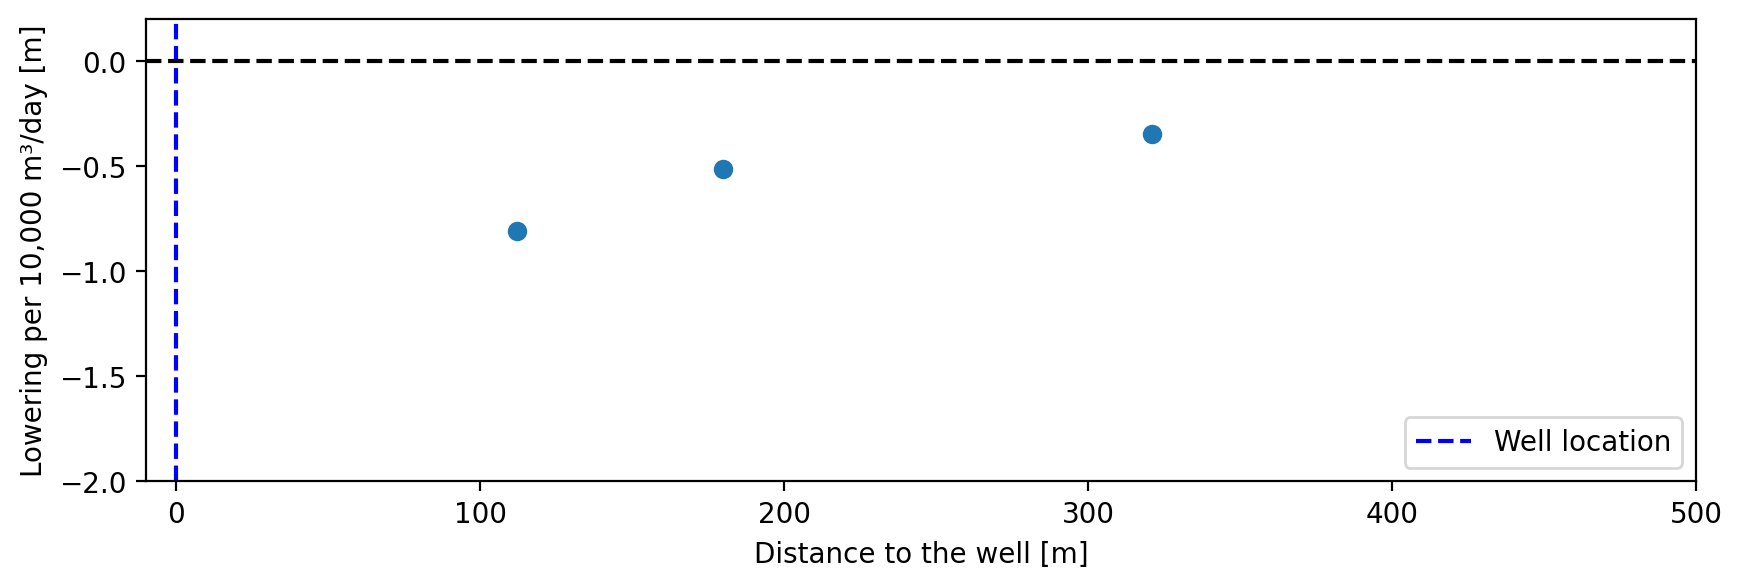

In [12]:
# Calculate average lowering due to extraction
avg_lowering_1 = ml.get_contribution('extraction').mean()
avg_lowering_2 = ml2.get_contribution('extraction').mean()
avg_lowering_3 = ml3.get_contribution('extraction').mean()

# Calculate average extraction over the observation period for each well
avg_extraction_1 = well[PB1.index[0]: PB1.index[-1]].mean()
avg_extraction_2 = well[PB2.index[0]: PB2.index[-1]].mean()
avg_extraction_3 = well[PB3.index[0]: PB3.index[-1]].mean()

# Normalize lowering per 10,000 m³/day of extraction
norm_lowering_1 = avg_lowering_1 / avg_extraction_1 * 10000
norm_lowering_2 = avg_lowering_2 / avg_extraction_2 * 10000
norm_lowering_3 = avg_lowering_3 / avg_extraction_3 * 10000

# Distances to the extraction well
dist_1 = 112
dist_2 = 180
dist_3 = 321

# Plotting normalized lowering vs. distance
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(np.array([dist_1, dist_2, dist_3]),
        np.array([norm_lowering_1, norm_lowering_2, norm_lowering_3]),
        color='C0', marker='o', ls='')

ax.axvline(x=0, ls='--', color='b', label='Well location')
ax.axhline(y=0, ls='--', color='k')
ax.set_xlim(-10, 500)
ax.set_ylim(-2, 0.2)
ax.set_xlabel('Distance to the well [m]')
ax.set_ylabel('Lowering per 10,000 m³/day [m]')
ax.legend();
